# CNN Model Building and Training Notebook

### This code is in developmental stage. Later will be translated for Azure Cloud implementation. 

### To use this code, dataset has been stored in google drive and gdrive path is mounted for use in notebook. 

In [1]:
try:
  import os, sys 
  #to be able to interact with Google Drive's operating system
  from google.colab import drive 
  #drive is a module that allows us use Python to interact with google drive
  drive.mount('/content/gdrive') 
  #mounting google drive allows us to work with its contents
  nb_path = '/content/notebooks'
  os.symlink('/content/gdrive/My Drive/Colab Notebooks', nb_path)
  sys.path.insert(0, nb_path)  # or append(nb_path)
  #The last three lines are what changes the path of the file.
except:
  print("Drive already mounted and ready to use!")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted and ready to use!


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

In [4]:
# Storing all required paths for later use

main_cwd = r'/content/gdrive/My Drive/Colab Notebooks/CNN_Medical_Imaging'
model_cwd = os.path.join(main_cwd, "Models")
dataset_cwd = os.path.join(main_cwd, "Datasets")
image_data_cwd = os.path.join(main_cwd, "Saved Image Data Arrays")
saved_models_cwd = os.path.join(main_cwd, "Saved_models")
model_checkpoints_cwd = os.path.join(main_cwd, "Model_check_points")
healthy_bones_dataset_cwd = os.path.join(dataset_cwd, "Healthy_bones")
fractured_bones_dataset_cwd = os.path.join(dataset_cwd, "Fractured_bones")
beyond_repair_bones_dataset_cwd = os.path.join(dataset_cwd, "Bones_beyond_repair")
train_test_valid_x_image_data = os.path.join(image_data_cwd, "train_test_valid_x_images_compressed_data_array_224.npz")
train_test_valid_y_labels_data = os.path.join(image_data_cwd, "train_test_valid_y_labels_compressed_array_224.npy")


In [5]:
# Importing required libraries

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import BatchNormalization, Activation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import warnings
import cv2
import re
import os


In [6]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")

## Helper functions

In [7]:
def get_cwd_files(path):

  ignore_files = [".gitkeep", ".gitignore"]
  path_files = os.listdir(path)
  path_files = [file for file in path_files if file not in ignore_files]

  return path_files

In [8]:
def get_image_data(image_data_process_directory, image_resize_value):

  # Classes for our prediction
  classification_classes = ["Healthy_bones", "Fractured_bones"]
  classification_classes_dict = {1:"Healthy_bones", 2:"Fractured_bones", 3:"Bones_beyond_repair"}
  # Set Image size
  img_size = image_resize_value

  #flag_counter = 0
  # Processing image to array
  #data = []
  image_data = []
  label_data = []
  for each_class in classification_classes:
    #flag_counter = 0
    class_category_number = classification_classes.index(each_class)
    bone_class_img_path = os.path.join(image_data_process_directory, each_class)
    #print(bone_class_img_path)
    bone_images = get_cwd_files(bone_class_img_path)
    for bone_image in bone_images:
      
      '''
      if flag_counter == 10:
        break
      flag_counter += 1'''

      bone_image_path = os.path.join(bone_class_img_path, bone_image)
      #print(bone_image_path)
      try:
        x_ray_image = load_img(bone_image_path, color_mode="grayscale", target_size=(img_size, img_size))
        x_ray_image = img_to_array(x_ray_image)
        image_data.append(x_ray_image)
        label_data.append(class_category_number)
        #print(x_ray_image.shape)
        #data.append([x_ray_image, class_category_number])
      except:
        print("Some error occured in fetching data!")

  
  #data = np.array(data)
  image_data = np.array(image_data)
  label_data = np.array(label_data) 
  
  return image_data, label_data  


## Main Program

Pre processing images to arrays and storing them is done only for the first run and for subsequent runs load the saved array images files for further work to reduce time.

In [9]:
# Processing train data images
train_test_valid_x, train_test_valid_y = get_image_data(dataset_cwd, image_resize_value = 128)

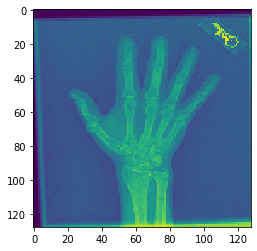

In [18]:
img_pil = array_to_img(train_test_valid_x[5222])
plt.imshow(img_pil, interpolation='nearest')
plt.show()

## Storing values of the image processed array data in csv files

In [19]:
# Storing Train_test_valid image array values

# For train_test_valid_x compressed values
np.savez_compressed("train_test_valid_x_greyscale_images_compressed_data_array_128", train_test_valid_array = train_test_valid_x)

# For train_test_valid_y compressed values
np.save("train_test_valid_y_greyscale_labels_compressed_array_128", train_test_valid_y)


## Loading Image arrays from the saved files

In [ ]:
# Loading Train image compressed array values

# For train_x values
model_train_test_valid_x = np.load(train_test_valid_x_image_data)["train_test_valid_array"]

# For train_y values
model_train_test_valid_y = np.load(train_test_valid_y_labels_data)

In [ ]:
# Creating train and test dataset
train_valid_x, model_test_x, train_valid_y, model_test_y = train_test_split(model_train_test_valid_x, model_train_test_valid_y, random_state = 42, stratify = model_train_test_valid_y, test_size = 0.10)

In [ ]:
# Creating train and test dataset
model_train_x, model_valid_x, model_train_y, model_valid_y = train_test_split(train_valid_x, train_valid_y, random_state = 42, stratify = train_valid_y, test_size = 0.15)

In [ ]:
# Removing specific variables from runtime to save RAM
del model_train_test_valid_x, model_train_test_valid_y, train_valid_x, train_valid_y

In [ ]:
# Normalizing values
model_train_x, model_train_y = model_train_x/255, model_train_y
model_test_x, model_test_y = model_test_x/255, model_test_y
model_valid_x, model_valid_y = model_valid_x/255, model_valid_y